# Functional connectivity: identifiability of subjects

In [1]:
# import necessary libraries
import pickle as pk
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from rich import pretty
from rich.progress import track
from tda import windowing
from tqdm import tqdm

pretty.install()

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/functional_connectivity/"
data_dir = "../data/preprocessing/"
data_out_dir = "../data/functional_connectivity/"
Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)
Path(data_out_dir).mkdir(parents=True, exist_ok=True)

## Load data

In [2]:
# cropped6_data = pk.load(open("../data/sixconditiondata.pkl", "rb"))

cropped6_data = pk.load(open(f"{data_dir}EEG_per_condition_dict.pkl", "rb"))

### Divide each condition into test and rest

In [3]:
n_windows = 2  # per condition

In [4]:
test_retest_data = dict()


for key in cropped6_data:
    filename = cropped6_data[key]["file"]
    group = cropped6_data[key]["group"]
    subject = cropped6_data[key]["subject"]
    condition = cropped6_data[key]["condition"]
    serie = cropped6_data[key]["series"]
    chs = cropped6_data[key]["channels"]

    # divide into windows
    windowed_series = windowing(serie, n_windows=n_windows)

    for i in range(n_windows):
        window_key = f"{subject}_{condition}_{i}"
        test_retest_data[window_key] = dict()

        test_retest_data[window_key]["file"] = window_key
        test_retest_data[window_key]["group"] = group
        test_retest_data[window_key]["subject"] = subject
        test_retest_data[window_key]["condition"] = condition
        test_retest_data[window_key]["window"] = i
        test_retest_data[window_key]["series"] = windowed_series[i]
        test_retest_data[window_key]["channels"] = chs

In [5]:
# pandas DataFrame from the raw_data_dict
test_retest_data_df = pd.DataFrame.from_dict(test_retest_data, orient="index")

In [6]:
test_retest_data_df

,file,group,subject,condition,window,series,channels
01_ROE_0,01_ROE_0,high,01,ROE,0,"[[1.0079775810241698e-05, 2.074808597564697e-0...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_1,01_ROE_1,high,01,ROE,1,"[[3.193559646606445e-07, 2.6713578701019288e-0...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_RCE_0,01_RCE_0,high,01,RCE,0,"[[3.207792043685913e-06, 3.530672192573547e-07...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_RCE_1,01_RCE_1,high,01,RCE,1,"[[-6.098387241363525e-06, -3.1650547981262207e...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_IND1_0,01_IND1_0,high,01,IND1,0,"[[-4.318517208099365e-06, -6.90339183807373e-0...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
...,...,...,...,...,...,...,...
31_IND2_1,31_IND2_1,low,31,IND2,1,"[[-6.951308250427246e-06, -7.668952941894531e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_NH_0,31_NH_0,low,31,NH,0,"[[4.52498197555542e-08, 3.130119144916534e-07,...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_NH_1,31_NH_1,low,31,NH,1,"[[-2.650147438049316e-06, -2.064450263977051e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_POST_0,31_POST_0,low,31,POST,0,"[[-3.4078838825225827e-06, -1.5270864963531493...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."


### Compute FC for test and retest

In [7]:
# empty dictionary to store EEG data
test_retest_corr = dict()

# loop through each file in the list of EEG files
for window_key in track(test_retest_data):
    # extract information from the dictionary
    subject = test_retest_data[window_key]["subject"]
    group = test_retest_data[window_key]["group"]
    serie = test_retest_data[window_key]["series"]
    condition = test_retest_data[window_key]["condition"]
    window = test_retest_data[window_key]["window"]
    ch = test_retest_data[window_key]["channels"]
    raw_data = pd.DataFrame(serie.T, columns=ch)
    corr = raw_data.corr()

    if group not in test_retest_corr:
        test_retest_corr[group] = dict()
    if subject not in test_retest_corr[group]:
        test_retest_corr[group][subject] = dict()
    if condition not in test_retest_corr[group][subject]:
        test_retest_corr[group][subject][condition] = dict()
    if window not in test_retest_corr[group][subject][condition]:
        test_retest_corr[group][subject][condition][window] = dict()

    test_retest_corr[group][subject][condition][window] = corr

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:02

In [8]:
pk.dump(test_retest_corr, open(f"{data_dir}test_retest_corr.pkl", "wb"))

## Identifiability of subjects

### Compute Iself and Iothers (matrices)

In [9]:
my_group = "high"

subject_list_high = []
condition_list = []
windows = [0, 1]

for subject in test_retest_corr[my_group]:
    my_subject = subject
    subject_list_high.append(my_subject)

for condition in test_retest_corr[my_group][my_subject]:
    my_condition = condition
    condition_list.append(condition)

In [10]:
idmatrixhighs_dict = dict()

for my_condition in condition_list:
    idmatrixhighs_dict[my_condition] = dict()

    idmatrixhighs = np.zeros((len(subject_list_high), len(subject_list_high)))

    for i, subject_i in enumerate(subject_list_high):
        FC_i0 = (
            test_retest_corr[my_group][subject_i][my_condition][0].to_numpy().flatten()
        )

        for j, subject_j in enumerate(subject_list_high):
            FC_j1 = (
                test_retest_corr[my_group][subject_j][my_condition][1]
                .to_numpy()
                .flatten()
            )
            # print("finestra2", m)

            if i != j:  # Iothers
                idmatrixhighs[i, j] = np.corrcoef(FC_i0, FC_j1)[0, 1]

            elif i == j:  # Iself
                idmatrixhighs[i, j] = np.corrcoef(FC_i0, FC_j1)[0, 1]

    idmatrixhighs_dict[my_condition]["idmatrix"] = idmatrixhighs

In [11]:
my_group = "low"

subject_list_low = []
condition_list = []
windows = [0, 1]

for subject in test_retest_corr[my_group]:
    my_subject = subject
    subject_list_low.append(my_subject)

for condition in test_retest_corr[my_group][my_subject]:
    my_condition = condition
    condition_list.append(condition)

In [12]:
idmatrixlows_dict = dict()

for my_condition in condition_list:
    idmatrixlows_dict[my_condition] = dict()

    idmatrixlows = np.zeros((len(subject_list_low), len(subject_list_low)))

    for i, subject_i in enumerate(subject_list_low):
        FC_i0 = (
            test_retest_corr[my_group][subject_i][my_condition][0].to_numpy().flatten()
        )

        for j, subject_j in enumerate(subject_list_low):
            FC_j1 = (
                test_retest_corr[my_group][subject_j][my_condition][1]
                .to_numpy()
                .flatten()
            )

            if i != j:
                idmatrixlows[i, j] = np.corrcoef(FC_i0, FC_j1)[0, 1]

            elif i == j:
                idmatrixlows[i, j] = np.corrcoef(FC_i0, FC_j1)[0, 1]

    idmatrixlows_dict[my_condition]["idmatrix"] = idmatrixlows

### Compute Idiff

In [13]:
idiffs_dict = dict()
idiffs_dict["high"] = dict()

for my_condition in idmatrixhighs_dict:
    idiffs_dict["high"][my_condition] = dict()
    idmatrix = idmatrixhighs_dict[my_condition]["idmatrix"]
    for i, subject_i in enumerate(subject_list_high):
        idiffs_dict["high"][my_condition][subject_i] = dict()

        iself_value = idmatrix[i, i]
        idiffs_dict["high"][my_condition][subject_i]["iself"] = iself_value

        iothers_sum = 0.0
        for j, subject_j in enumerate(subject_list_high):
            if i != j:
                iothers_sum += idmatrix[i, j] + idmatrix[j, i]
        iothers_mean = iothers_sum / (2 * (len(subject_list_high) - 1))
        idiffs_dict["high"][my_condition][subject_i]["iothers"] = iothers_mean

In [14]:
idiffs_dict["low"] = dict()

for my_condition in idmatrixlows_dict:
    idiffs_dict["low"][my_condition] = dict()
    idmatrix = idmatrixlows_dict[my_condition]["idmatrix"]
    for i, subject_i in enumerate(subject_list_low):
        idiffs_dict["low"][my_condition][subject_i] = dict()

        iself_value = idmatrix[i, i]
        idiffs_dict["low"][my_condition][subject_i]["iself"] = iself_value

        iothers_sum = 0.0
        for j, subject_j in enumerate(subject_list_low):
            if i != j:
                iothers_sum += idmatrix[i, j] + idmatrix[j, i]
        iothers_mean = iothers_sum / (2 * (len(subject_list_low) - 1))
        idiffs_dict["low"][my_condition][subject_i]["iothers"] = iothers_mean

In [15]:
iself_values = []
iothers_values = []

# Calcolo delle medie
for condition in idiffs_dict["high"]:
    for subject in idiffs_dict["high"][condition]:
        iself_value = idiffs_dict["high"][condition][subject]["iself"]
        iothers_value = idiffs_dict["high"][condition][subject]["iothers"]

        iself_values.append(iself_value)
        iothers_values.append(iothers_value)

    # Calcolo delle medie complessive
    iself_mean = np.mean(iself_values)
    iothers_mean = np.mean(iothers_values)

    # Calcolo della differenza
    idiff = iself_mean - iothers_mean

    idiffs_dict["high"][condition]["idiff"] = idiff

In [16]:
iself_values = []
iothers_values = []

# Calcolo delle medie
for condition in idiffs_dict["low"]:
    for subject in idiffs_dict["low"][condition]:
        iself_value = idiffs_dict["low"][condition][subject]["iself"]
        iothers_value = idiffs_dict["low"][condition][subject]["iothers"]

        iself_values.append(iself_value)
        iothers_values.append(iothers_value)

    # Calcolo delle medie complessive
    iself_mean = np.mean(iself_values)
    iothers_mean = np.mean(iothers_values)

    # Calcolo della differenza
    idiff = iself_mean - iothers_mean

    idiffs_dict["low"][condition]["idiff"] = idiff

### Draw matrices per condition and group

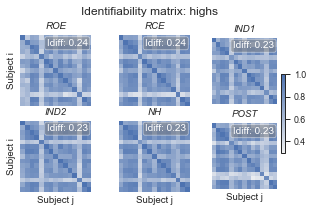

In [17]:
cmap = sb.color_palette("light:b", as_cmap=True)

fig, axs = plt.subplots(
    2, 3, figsize=(5, 3), sharey=True, sharex=True
)  # , layout="constrained")

for i, condition in enumerate(condition_list):

    ax = axs.flat[i]

    ax = sb.heatmap(
        idmatrixhighs_dict[condition]["idmatrix"],
        cmap=cmap,
        cbar=False,
        square=True,
        # annot=True,
        fmt=".3f",
        # annot_kws={"fontsize": 6},
        vmin=0.3,  # Sostituisci con il valore minimo desiderato
        vmax=1,
        xticklabels=[],  # subject_list_high,
        yticklabels=[],  # subject_list_high,
        ax=ax,
    )

    # print(idmatrixhighs_dict[condition]["idmatrix"].max())
    # print(idmatrixhighs_dict[condition]["idmatrix"].min())

    idiff = idiffs_dict["high"][condition]["idiff"]
    title = f"Highs {condition}, Idiff: {idiff:.3f}"
    ax.set_title(condition, style="italic")

    t = ax.text(
        0.95,
        0.95,
        f"Idiff: {idiff:.2f}",
        va="top",
        ha="right",
        transform=ax.transAxes,
        color="w",
    )
    t.set_bbox(dict(facecolor="grey", alpha=0.5, boxstyle="round,pad=0.2"))

for ax in axs[:, 0]:
    ax.set_ylabel("Subject i")
for ax in axs[-1, :]:
    ax.set_xlabel("Subject j")

title = "Identifiability matrix: highs"
plt.suptitle(title)
plt.subplots_adjust(top=0.85)

fig.colorbar(ax.get_children()[0], ax=axs[:, -1], shrink=0.5)  # , ticks=[0, 0.5, 1])

fig_name = f"FC_subject_idiff_matrix_conditions_highs_{n_windows}_windows"
plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")

plt.show()

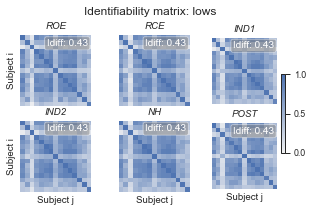

In [18]:
cmap = sb.color_palette("light:b", as_cmap=True)

fig, axs = plt.subplots(
    2, 3, figsize=(5, 3), sharey=True, sharex=True
)  # , layout="constrained")

for i, condition in enumerate(condition_list):

    ax = axs.flat[i]

    ax = sb.heatmap(
        idmatrixlows_dict[condition]["idmatrix"],
        cmap=cmap,
        cbar=False,
        square=True,
        # annot=True,
        fmt=".3f",
        # annot_kws={"fontsize": 6},
        vmin=0,  # Sostituisci con il valore minimo desiderato
        vmax=1,
        xticklabels=[],  # subject_list_high,
        yticklabels=[],  # subject_list_high,
        ax=ax,
    )

    # print(idmatrixlows_dict[condition]["idmatrix"].max())
    # print(idmatrixlows_dict[condition]["idmatrix"].min())

    idiff = idiffs_dict["low"][condition]["idiff"]
    title = f"Lows {condition}, Idiff: {idiff:.3f}"
    ax.set_title(condition, style="italic")

    t = ax.text(
        0.95,
        0.95,
        f"Idiff: {idiff:.2f}",
        va="top",
        ha="right",
        transform=ax.transAxes,
        color="w",
    )
    t.set_bbox(dict(facecolor="grey", alpha=0.5, boxstyle="round,pad=0.2"))

for ax in axs[:, 0]:
    ax.set_ylabel("Subject i")
for ax in axs[-1, :]:
    ax.set_xlabel("Subject j")

title = "Identifiability matrix: lows"
plt.suptitle(title)
plt.subplots_adjust(top=0.85)

fig.colorbar(ax.get_children()[0], ax=axs[:, -1], shrink=0.5, ticks=[0, 0.5, 1])

fig_name = f"FC_subject_idiff_matrix_conditions_lows_{n_windows}_windows"
plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")

plt.show()
# plt.close()

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_54373/3295319520.py:71: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.85)


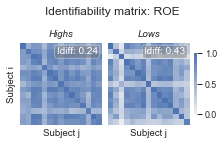

In [19]:
cmap = sb.color_palette("light:b", as_cmap=True)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(3, 2), sharey=True, sharex=True, layout="constrained"
)

condition = "ROE"

ax1 = sb.heatmap(
    idmatrixhighs_dict[condition]["idmatrix"],
    cmap=cmap,
    cbar=False,
    square=True,
    # annot=True,
    fmt=".3f",
    # annot_kws={"fontsize": 6},
    vmin=0,  # Sostituisci con il valore minimo desiderato
    vmax=1,
    xticklabels=[],  # subject_list_high,
    yticklabels=[],  # subject_list_high,
    ax=ax1,
)

idiff = idiffs_dict["high"][condition]["idiff"]
ax1.set_title("Highs", style="italic")

t = ax1.text(
    0.95,
    0.95,
    f"Idiff: {idiff:.2f}",
    va="top",
    ha="right",
    transform=ax1.transAxes,
    color="w",
)
t.set_bbox(dict(facecolor="grey", alpha=0.5, boxstyle="round,pad=0.2"))

ax2 = sb.heatmap(
    idmatrixlows_dict[condition]["idmatrix"],
    cmap=cmap,
    cbar=True,
    square=True,
    # annot=True,
    fmt=".3f",
    # annot_kws={"fontsize": 6},
    vmin=0,  # Sostituisci con il valore minimo desiderato
    vmax=1,
    xticklabels=[],  # subject_list_high,
    yticklabels=[],  # subject_list_high,
    ax=ax2,
    cbar_kws=dict(shrink=0.5),
)

idiff = idiffs_dict["low"][condition]["idiff"]
ax2.set_title("Lows", style="italic")

t = ax2.text(
    0.95,
    0.95,
    f"Idiff: {idiff:.2f}",
    va="top",
    ha="right",
    transform=ax2.transAxes,
    color="w",
)
t.set_bbox(dict(facecolor="grey", alpha=0.5, boxstyle="round,pad=0.2"))


title = f"Identifiability matrix: {condition}"
plt.suptitle(title)
plt.subplots_adjust(top=0.85)

ax1.set_ylabel("Subject i")
ax1.set_xlabel("Subject j")
ax2.set_xlabel("Subject j")

fig_name = f"FC_subject_idiff_matrix_{condition}_highlow_{n_windows}_windows"
plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")

plt.show()

### Viz Idiff distributions

In [20]:
idiff_distribution = dict()

idiff_distribution["high"] = dict()

for condition in condition_list:
    idiff_distribution["high"][condition] = dict()

    idmatrix_highs = idmatrixhighs_dict[condition]["idmatrix"]

    for i, subject_i in enumerate(subject_list_high):
        idiff_i = idmatrix_highs[i, i] - np.mean(np.delete(idmatrix_highs[i, :], i))
        idiff_distribution["high"][condition][subject_i] = idiff_i

idiff_distribution["low"] = dict()

for condition in condition_list:
    idiff_distribution["low"][condition] = dict()

    idmatrix_lows = idmatrixlows_dict[condition]["idmatrix"]

    for i, subject_i in enumerate(subject_list_low):
        idiff_i = idmatrix_lows[i, i] - np.mean(np.delete(idmatrix_lows[i, :], i))
        idiff_distribution["low"][condition][subject_i] = idiff_i

In [22]:
groups = ["high", "low"]

data = []

for group in groups:
    for condition in condition_list:
        for subject_i, distribution in idiff_distribution[group][condition].items():
            if isinstance(distribution, (int, float)):  # Verifica se è int o float
                distribution_list = [distribution]  # Crea una lista con il valore
            else:
                distribution_list = distribution.tolist()  # Converti in una lista
            for value in distribution_list:
                data.append(
                    {
                        "Group": group,
                        "Condition": condition,
                        "Subject": subject_i,
                        "Data": value,
                    }
                )

# Crea un DataFrame con le distribuzioni
df = pd.DataFrame(data)

In [23]:
df

,Group,Condition,Subject,Data
0,high,ROE,01,0.362353
1,high,ROE,02,0.200803
2,high,ROE,03,0.178728
3,high,ROE,04,0.184328
4,high,ROE,05,0.338107
...,...,...,...,...
175,low,POST,27,0.336996
176,low,POST,28,0.327475
177,low,POST,29,0.419431
178,low,POST,30,0.484738


In [24]:
# save to file
df.to_csv(f"{data_out_dir}idiff_distrib.csv", index=False)

In [26]:
data_out_dir

'../data/functional_connectivity/'

#### boxplots

/Users/maxime/.pyenv/versions/venv_hypno/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)


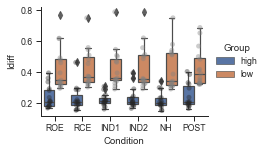

In [25]:
fig, ax = plt.subplots(figsize=(3, 2))

sb.boxplot(x="Condition", y="Data", data=df, hue="Group")
sb.stripplot(
    x="Condition",
    y="Data",
    data=df,
    hue="Group",
    dodge=True,
    legend=False,
    alpha=0.4,
    color="grey",
)

sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

ax.set_ylabel("Idiff")

sb.despine()

fig_name = f"FC_subject_idiff_distrib_{n_windows}_windows"
plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")

#### barplots

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RCE_high vs. RCE_low: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00
ROE_high vs. ROE_low: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=1.000e+00
IND1_high vs. IND1_low: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00
IND2_high vs. IND2_low: Wilcoxon test (paired samples), P_val:3.052e-04 Stat=3.000e+00
NH_high vs. NH_low: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00
POST_high vs. POST_low: Wilcoxon test (paired samples), P_val:4.272e-04 Stat=4.000e+00


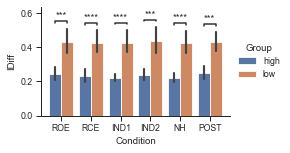

In [171]:
fig, ax = plt.subplots(figsize=(3.4, 2))

order = [("ROE"), ("RCE"), ("IND1"), ("IND2"), ("NH"), ("POST")]


# Crea un barplot delle distribuzioni
sb.barplot(x="Condition", y="Data", data=df, hue="Group")

# Titolo del grafico
# plt.title("Idiff distribuition")

var = order
pairs1 = [[(i, "high"), (i, "low")] for i in var]
# pairs2 = [[(i, "low"), (j, "low")] for i, j in combinations(["ROE", "RCE", "NH"], 2)]
pairs3 = [[(i, "high"), (j, "high")] for i, j in combinations(["ROE", "RCE", "NH"], 2)]

pairs = pairs1  # + pairs3

from statannotations.Annotator import Annotator

annotator = Annotator(
    ax,
    pairs,
    data=df,
    x="Condition",
    y="Data",
    hue="Group",
    order=order,
    hue_order=["high", "low"],
)
annotator.configure(test="Wilcoxon", text_format="star", loc="inside")
annotator.apply_and_annotate()

sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

ax.set_ylabel("IDiff")

sb.despine()

fig_name = f"FC_subject_idiff_distrib_barplots_{n_windows}_windows"
plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")


plt.show()